# NeuroCluster:
<font size= 4> Non-parametric cluster-based permutation testing to identify neurophysiological encoding of continuous variables with time-frequency resolution

Authors: Christina Maher & Alexandra Fink-Skular \
Updated: 07/23/2024 by AFS

In [2]:
import numpy as np
import pandas as pd
import mne
from glob import glob
from scipy.stats import zscore, t, linregress, ttest_ind, ttest_rel, ttest_1samp 
import os 
import re
import h5io
import pickle 
import time 
import datetime 
from joblib import Parallel, delayed
import statsmodels.api as sm 
from scipy.ndimage import label 
import statsmodels.formula.api as smf
# from tqdm import tqdm
import operator
import tqdm
import matplotlib.pyplot as plt
import inspect


import warnings
warnings.filterwarnings('ignore')

# keep this so we can use our respective paths for testing
current_user = 'alie'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
date = datetime.date.today().strftime('%m%d%Y')
print(date)

07232024


In [5]:
if current_user == 'christina':
    base_dir = '/Users/christinamaher/Documents/GitHub/NeuroCluster/scripts/'
    data_dir = '/Users/christinamaher/Documents/GitHub/NeuroCluster/'
    tfr_dir  = f'{data_dir}tfr/'
    anat_dir = f'{data_dir}anat/'
elif current_user == 'alie':
    # base_dir = '/hpc/users/finka03/NeuroCluster/NeuroCluster/'
    # swb_dir  = '/sc/arion/projects/guLab/Alie/SWB/'
    # tfr_dir  = f'{swb_dir}ephys_analysis/data/'
    # beh_dir  = f'{swb_dir}swb_behav_models/data/behavior_preprocessed/'
    # anat_dir = f'{swb_dir}ephys_analysis/recon_labels/'
    # save_dir = f'{base_dir}/data/'
    
    base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/NeuroCluster/NeuroCluster/NeuroCluster/scripts/'
    data_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
    tfr_dir  = f'{data_dir}ephys_analysis/data/'
    beh_dir  = f'{data_dir}behavior_analysis/behavior_preprocessed/'
    anat_dir = f'{data_dir}anat_recons/'

In [6]:
# load functions 
import sys
sys.path.append(f'{base_dir}')
# sys.path.append(f'{base_dir}scripts/')

from tfr_cluster_test import *
from helper_utils import *
# from plotting_utils import * 

# Step 1: Format Input Data (Currently within-subject)
- neural input: np.array (n_channels x n_epochs x n_freqs x n_times)
- regressor data: np.array (numpy array: n_epochs x n_features)

In [7]:
# save_data = tfr_test_data.copy()
# save_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/NeuroCluster/NeuroCluster/NeuroCluster/template_data/'
# f = open(f'{save_path}sample_tfr_data.bin',"wb")
# np.save(f,save_data)
# f.close()

In [67]:
# load epoched data for single subj
if current_user == 'alie':
    permute_var = 'decisionCPE'
    subj_id     = 'MS041'   
    power_epochs = mne.time_frequency.read_tfrs(fname=f'{tfr_dir}{subj_id}/{subj_id}_CpeOnset-tfr.h5')[0]
    anat_file = pd.read_csv('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/roi_reref_labels_master.csv')
    ofc_elecs = anat_file[(anat_file.subj_id == 'MS041')&(anat_file.roi == 'ofc')].reref_ch_names.to_list()
    ins_elecs = anat_file[(anat_file.subj_id == 'MS041')&(anat_file.roi == 'ains')].reref_ch_names.to_list()
    dataset_elecs = ofc_elecs + ins_elecs #ins_elecs[:-1]

elif current_user == 'christina':
    permute_var = 'ev_zscore'
    subj_id     = 'MS009'   
    power_epochs = mne.time_frequency.read_tfrs(fname=f'{tfr_dir}/{subj_id}_tfr.h5')[0]

Reading /Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/MS041/MS041_CpeOnset-tfr.h5 ...


In [71]:
dataset_elecs

['lmolf1-lmolf2',
 'lmolf2-lmolf3',
 'lmolf3-lmolf4',
 'lmolf4-lmolf5',
 'lmolf5-lmolf6',
 'lmolf6-lmolf7',
 'lmolf7-lmolf8',
 'lmolf8-lmolf9',
 'lmolf9-lmolf10',
 'rmolf1-rmolf2',
 'rmolf2-rmolf3',
 'rmolf3-rmolf4',
 'rmolf4-rmolf5',
 'lais1-lais2',
 'lais2-lais3',
 'lais3-lais4']

In [69]:
rename_elecs = {f'{elec}':'_'.join(['channel',str(ix)]) for ix,elec in enumerate(dataset_elecs)}
rename_elecs

{'lmolf1-lmolf2': 'channel_0',
 'lmolf2-lmolf3': 'channel_1',
 'lmolf3-lmolf4': 'channel_2',
 'lmolf4-lmolf5': 'channel_3',
 'lmolf5-lmolf6': 'channel_4',
 'lmolf6-lmolf7': 'channel_5',
 'lmolf7-lmolf8': 'channel_6',
 'lmolf8-lmolf9': 'channel_7',
 'lmolf9-lmolf10': 'channel_8',
 'rmolf1-rmolf2': 'channel_9',
 'rmolf2-rmolf3': 'channel_10',
 'rmolf3-rmolf4': 'channel_11',
 'rmolf4-rmolf5': 'channel_12',
 'lais1-lais2': 'channel_13',
 'lais2-lais3': 'channel_14',
 'lais3-lais4': 'channel_15'}

In [70]:
save_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/NeuroCluster/NeuroCluster/NeuroCluster/data/sample_ieeg/'


In [79]:
for elec_name in dataset_elecs:
    channel_data = np.squeeze(power_epochs.copy().pick_channels([elec_name])._data)
    elec_id = rename_elecs[elec_name]
    np.save(f'{save_path}{elec_id}.npy',channel_data)


In [81]:
channel_data

array([[[ 1.28841016e-01,  1.30837536e-01,  1.32769766e-01, ...,
         -5.38115135e-01, -5.40707241e-01, -5.43347792e-01],
        [-6.51343959e-02, -6.64403191e-02, -6.77404596e-02, ...,
         -6.24116782e-01, -6.25804793e-01, -6.27492786e-01],
        [-5.13664223e-01, -5.15319019e-01, -5.16845148e-01, ...,
         -8.40808959e-01, -8.43509471e-01, -8.46080811e-01],
        ...,
        [ 7.02161653e-01,  4.42605512e-01,  2.58231389e-01, ...,
         -7.69171132e-01, -4.15547993e-01,  6.47511508e-02],
        [ 6.67756001e-01,  6.67567963e-01,  5.54186252e-01, ...,
          2.12204486e+00,  2.01550058e+00,  2.13329893e+00],
        [-2.51982447e-01, -2.11957210e-01, -3.23169059e-01, ...,
          1.57186782e+00,  7.03303640e-01,  4.37352758e-01]],

       [[-2.53086740e-01, -2.51782938e-01, -2.50424021e-01, ...,
          3.12568385e+00,  3.12552270e+00,  3.12497800e+00],
        [-6.79104966e-01, -6.83451203e-01, -6.87707217e-01, ...,
          4.06525444e+00,  4.06102924e

In [78]:
# np.squeeze(power_epochs._data[:,dev_ch_idx,:,:].copy())

np.squeeze(channel_data).shape



(150, 30, 1501)

In [73]:
sample_tfr_data

{'channel_0': array([[[[-0.25573821, -0.25684948, -0.25796175, ..., -0.33471591,
           -0.33553004, -0.33639022],
          [-0.57492725, -0.57768332, -0.5803921 , ..., -0.24353704,
           -0.24688196, -0.25029807],
          [-0.78613162, -0.79067828, -0.79514356, ..., -0.16447153,
           -0.17191765, -0.17946376],
          ...,
          [ 0.03827162, -0.27727671, -0.56489865, ..., -0.93672942,
           -0.92967634, -0.92664537],
          [ 0.63831191,  0.35615303,  0.03284906, ..., -0.98954627,
           -0.97566733, -0.95129212],
          [ 0.44642771,  0.36107439,  0.13794654, ..., -0.68850635,
           -0.60803614, -0.51784659]]],
 
 
        [[[-0.74312277, -0.74202426, -0.74095247, ..., -0.41485528,
           -0.41807955, -0.42134694],
          [-0.38806179, -0.38466085, -0.38131011, ..., -0.45239227,
           -0.45243839, -0.45258917],
          [ 0.07971178,  0.08538995,  0.09100199, ..., -0.38209731,
           -0.38210638, -0.38228102],
          ..

In [65]:
np.load(f'{save_path}sample_tfr_data.npz').files

['channel_0',
 'channel_1',
 'channel_2',
 'channel_3',
 'channel_4',
 'channel_5',
 'channel_6',
 'channel_7',
 'channel_8',
 'channel_9',
 'channel_10',
 'channel_11',
 'channel_12',
 'channel_13',
 'channel_14',
 'channel_15']

In [ ]:
# sample_tfr_data = np.load(open(f'{save_path}sample_tfr_data.npy','rb'))

In [15]:
# anat_file = pd.read_csv('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/roi_reref_labels_master.csv')
# ofc_elecs = anat_file[(anat_file.subj_id == 'MS041')&(anat_file.roi == 'ofc')].reref_ch_names.to_list()
# ins_elecs = anat_file[(anat_file.subj_id == 'MS041')&(anat_file.roi == 'ains')].reref_ch_names.to_list()
# dataset_elecs = ofc_elecs+ins_elecs
# tfr_test_data = power_epochs.pick_channels(dataset_elecs)._data


In [74]:
dataset_elecs[-3]

'lais1-lais2'

In [31]:
# save_data = tfr_test_data.copy()
# save_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/NeuroCluster/NeuroCluster/NeuroCluster/template_data/'
# f = open(f'{save_path}sample_tfr_data.bin',"wb")
# np.save(f,save_data)
# f.close()

# sample_tfr_data = np.load(open(f'{save_path}sample_tfr_data.bin','rb'))

In [43]:
sample_tfr_data

array([[[[-5.57836656e-02, -5.91201255e-02, -6.25191291e-02, ...,
          -6.57402675e-01, -6.59572841e-01, -6.61760413e-01],
         [-3.00067224e-01, -3.06219806e-01, -3.12423883e-01, ...,
          -7.80111500e-01, -7.81876349e-01, -7.83610726e-01],
         [-4.06786856e-01, -4.16847733e-01, -4.27021743e-01, ...,
          -9.40095968e-01, -9.40507784e-01, -9.40811278e-01],
         ...,
         [-9.19371637e-01, -9.88034773e-01, -9.91205532e-01, ...,
           1.96184499e+00,  2.05756559e+00,  1.97145564e+00],
         [-4.83324743e-01, -3.15413629e-01, -1.02766886e-01, ...,
          -2.90162328e-01, -2.20231319e-01, -1.99433128e-01],
         [-8.44454438e-01, -5.15526044e-01,  3.42571040e-02, ...,
          -3.56234016e-01, -5.33852555e-01, -5.77118114e-01]],

        [[-7.11499219e-01, -7.10329371e-01, -7.09135810e-01, ...,
          -9.22612229e-01, -9.24138118e-01, -9.25654810e-01],
         [-8.98547720e-01, -8.97885882e-01, -8.97166240e-01, ...,
          -9.70320690e

In [55]:
# set ROI for single ROI anaylsis 
if current_user == 'alie':
#     roi = 'ains'
    # set all variables included mutliple regression 
    multi_reg_vars = ['GambleChoice','decisionCPE']
    # set main variable of interest for permutations 
    permute_var = 'decisionCPE'
    # load subj behavior data 
#     beh_df = pd.read_csv(f'{beh_dir}{subj_id}_task_data')
    beh_df = power_epochs.metadata.copy()
    # beh_df['subj_id'] = subj_id
    # add TrialEV to df
    beh_df['TrialEV'] = beh_df.GambleEV - beh_df.SafeBet
#     # clean subj dataframe from fail trials/nan values in vars of interest     
#     # beh_df = beh_df[(beh_df.GambleChoice=='gamble')|(beh_df.GambleChoice=='safe')]
# #     beh_df = beh_df[(beh_df.Outcome=='good')|(beh_df.Outcome=='bad')]
    
#     # zscore continuous variables 
#     beh_df[multi_reg_vars[1:]] = pd.DataFrame({f'{var}':zscore(beh_df[var])  for var in multi_reg_vars[1:]})
#     # format final beh_df
#     beh_df = beh_df[multi_reg_vars].reset_index(drop=True) 
#     # convert choice to categorical variable
#     beh_df['GambleChoice'] = beh_df['GambleChoice'].astype('category')

elif current_user == 'christina':
    beh_df = prepare_regressor_df(power_epochs)
    ## new function for getting elecs in ROI
    roi = ['lpfc','ofc']
    roi_subj_elecs = prepare_anat_dic(roi, f'{anat_dir}master_labels.csv')
    roi_subj_elecs


In [56]:
beh_df.columns.to_list()

['Round',
 'RT',
 'CpeOnset',
 'GambleChoice',
 'TrialType',
 'SafeBet',
 'LowBet',
 'HighBet',
 'GambleEV',
 'Outcome',
 'Profit',
 'TotalProfit',
 'CR',
 'choiceEV',
 'RPE',
 'decisionCPE',
 'decisionRegret',
 'decisionRelief',
 'decisionCF',
 'TrialEV']

In [57]:
sample_behavior_data = beh_df[[
 'GambleChoice',
 'TrialType',
 'TrialEV',
 'TotalProfit',
 'decisionCPE']]

In [61]:
dummy_var_names = ['outcome','condition','expected_value','reward_total','error']
rename_dict = {f'{var}':f'{dummy_var_names[ix]}' for ix,var in enumerate(sample_behavior_data.columns)}
sample_behavior_data = sample_behavior_data.rename(columns = rename_dict)


In [67]:
sample_behavior_data.outcome.replace(to_replace=dict(gamble='bad', safe='good'), inplace=True)


In [69]:
sample_behavior_data.condition.replace(to_replace=dict(loss='low', mix='medium',gain='high'), inplace=True)


In [70]:
sample_behavior_data

,outcome,condition,expected_value,reward_total,error
0,bad,high,0.660,12.52,1.92
1,good,high,-0.095,13.12,0.60
2,good,low,0.000,12.92,0.20
3,bad,high,0.160,12.92,-0.40
4,bad,high,0.160,13.64,0.52
...,...,...,...,...,...
145,bad,high,0.450,14.72,-0.30
146,bad,low,-0.320,13.28,-1.04
147,good,medium,-0.175,13.28,-0.15
148,bad,low,-0.230,13.28,0.40


In [72]:
save_path

'/Users/alexandrafink/Documents/GraduateSchool/SaezLab/NeuroCluster/NeuroCluster/NeuroCluster/template_data/'

In [71]:
sample_behavior_data.to_csv(f'{save_path}sample_behavior_data.csv')

In [54]:
sample_behavior_data


,Round,RT,CpeOnset,GambleChoice,TrialType,SafeBet,LowBet,HighBet,GambleEV,Outcome,Profit,TotalProfit,CR,choiceEV,RPE,decisionCPE,decisionRegret,decisionRelief,decisionCF
0,1,2.604102,324.496289,gamble,gain,0.6,0.00,2.52,1.260,good,2.52,12.52,0.0,1.26,1.26,1.92,0.00,1.92,0.60
1,2,2.167664,333.241719,safe,gain,0.6,0.00,1.01,0.505,good,0.60,13.12,0.6,0.00,0.00,0.60,0.00,0.60,0.00
2,3,1.211903,341.970560,safe,loss,-0.2,-0.40,0.00,-0.200,good,-0.20,12.92,-0.2,0.00,0.00,0.20,0.00,0.20,-0.40
3,4,1.291330,358.978148,gamble,gain,0.4,0.00,1.12,0.560,bad,0.00,12.92,0.0,0.56,-0.56,-0.40,-0.40,0.00,0.40
4,5,1.579269,367.506980,gamble,gain,0.2,0.00,0.72,0.360,good,0.72,13.64,0.0,0.36,0.36,0.52,0.00,0.52,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,4.044669,2025.830255,gamble,gain,0.3,0.00,1.50,0.750,bad,0.00,14.72,0.0,0.75,-0.75,-0.30,-0.30,0.00,0.30
146,147,3.274145,2035.674996,gamble,loss,-0.4,-1.44,0.00,-0.720,bad,-1.44,13.28,0.0,-0.72,-0.72,-1.04,-1.04,0.00,-0.40
147,148,1.782060,2050.367266,safe,mix,0.0,-0.50,0.15,-0.175,bad,0.00,13.28,0.0,0.00,0.00,-0.15,-0.15,0.00,0.15
148,149,1.180759,2058.079837,gamble,loss,-0.4,-1.26,0.00,-0.630,good,0.00,13.28,0.0,-0.63,0.63,0.40,0.00,0.40,-0.40


In [9]:
multi_reg_vars

['GambleChoice', 'decisionCPE']

In [41]:
tfr_test_data.shape

(150, 16, 30, 1501)

In [34]:
progress_bar = tqdm(elec_df.label, ascii=True, desc='Aggregating TFRs')

        for elec_ix, chan in enumerate(progress_bar):


In [38]:
sample_tfr_data = np.load(open(f'{save_path}sample_tfr_data.bin','rb'))

In [ ]:
sample_tfr_data

In [78]:
#### class TFR_Cluster_Test dev + debugging

if current_user == 'alie':

    # subset single electrode tfr data + behav data
    dev_ch_idx     = power_epochs.ch_names.index('lais1-lais2')
    ch_name        = 'lais1-lais2'
    tfr_data       = np.squeeze(power_epochs._data[:,dev_ch_idx,:,:].copy())
    predictor_data = beh_df.copy()
    
    # predictor_data = predictor_data.drop(columns='subj_id')

elif current_user == 'christina':
    
        # subset single electrode tfr data + behav data
        # predictor_data = predictor_data.drop(columns=['condition','chosen_shape_current_trial','chosen_color_current_trial','chosen_shape_previous_trial','chosen_color_previous_trial','ev'])
        tfr_data = np.squeeze(power_epochs._data[:,0,:,:].copy())
        ch_name = power_epochs.info['ch_names'][0]

In [79]:
predictor_data

,Round,RT,CpeOnset,GambleChoice,TrialType,SafeBet,LowBet,HighBet,GambleEV,Outcome,Profit,TotalProfit,CR,choiceEV,RPE,decisionCPE,decisionRegret,decisionRelief,decisionCF,TrialEV
0,1,2.604102,324.496289,gamble,gain,0.6,0.00,2.52,1.260,good,2.52,12.52,0.0,1.26,1.26,1.92,0.00,1.92,0.60,0.660
1,2,2.167664,333.241719,safe,gain,0.6,0.00,1.01,0.505,good,0.60,13.12,0.6,0.00,0.00,0.60,0.00,0.60,0.00,-0.095
2,3,1.211903,341.970560,safe,loss,-0.2,-0.40,0.00,-0.200,good,-0.20,12.92,-0.2,0.00,0.00,0.20,0.00,0.20,-0.40,0.000
3,4,1.291330,358.978148,gamble,gain,0.4,0.00,1.12,0.560,bad,0.00,12.92,0.0,0.56,-0.56,-0.40,-0.40,0.00,0.40,0.160
4,5,1.579269,367.506980,gamble,gain,0.2,0.00,0.72,0.360,good,0.72,13.64,0.0,0.36,0.36,0.52,0.00,0.52,0.20,0.160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,4.044669,2025.830255,gamble,gain,0.3,0.00,1.50,0.750,bad,0.00,14.72,0.0,0.75,-0.75,-0.30,-0.30,0.00,0.30,0.450
146,147,3.274145,2035.674996,gamble,loss,-0.4,-1.44,0.00,-0.720,bad,-1.44,13.28,0.0,-0.72,-0.72,-1.04,-1.04,0.00,-0.40,-0.320
147,148,1.782060,2050.367266,safe,mix,0.0,-0.50,0.15,-0.175,bad,0.00,13.28,0.0,0.00,0.00,-0.15,-0.15,0.00,0.15,-0.175
148,149,1.180759,2058.079837,gamble,loss,-0.4,-1.26,0.00,-0.630,good,0.00,13.28,0.0,-0.63,0.63,0.40,0.00,0.40,-0.40,-0.230


## Step 2: Find Real Clusters
- Use TFRClusterTest class code to run multivariate regression
- Allows for multiple regression implementation and pixel paralellization, so with more speed improvements will ultimately be worth it.

In [81]:
sample_behavior_data

,outcome,condition,expected_value,reward_total,error
0,bad,high,0.660,12.52,1.92
1,good,high,-0.095,13.12,0.60
2,good,low,0.000,12.92,0.20
3,bad,high,0.160,12.92,-0.40
4,bad,high,0.160,13.64,0.52
...,...,...,...,...,...
145,bad,high,0.450,14.72,-0.30
146,bad,low,-0.320,13.28,-1.04
147,good,medium,-0.175,13.28,-0.15
148,bad,low,-0.230,13.28,0.40


In [82]:
predictor_data = sample_behavior_data[['outcome','error']]

In [83]:
predictor_data

,outcome,error
0,bad,1.92
1,good,0.60
2,good,0.20
3,bad,-0.40
4,bad,0.52
...,...,...
145,bad,-0.30
146,bad,-1.04
147,good,-0.15
148,bad,0.40


In [87]:
permute_var = 'error'

In [88]:
cluster_test  = TFR_Cluster_Test(tfr_data,predictor_data,permute_var)
cluster_test

In [89]:
betas, tstats = cluster_test.tfr_regression()


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 2624 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 6272 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 12608 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 20096 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 28736 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 38528 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 45030 out of 45030 | elapsed:   28.5s finished


In [90]:
tstats

array([[ 0.87434933,  0.86044113,  0.84637328, ..., -0.19086834,
        -0.19161677, -0.19257566],
       [ 1.13658979,  1.12881235,  1.12082769, ..., -0.297019  ,
        -0.29630342, -0.29597166],
       [ 1.11804259,  1.11384358,  1.10941664, ..., -0.44654584,
        -0.44445835, -0.44284704],
       ...,
       [-0.52356764, -0.62622569, -0.65629638, ..., -1.54940863,
        -1.18605644, -0.73853189],
       [-0.4809192 , -0.53452091, -0.5390014 , ..., -2.26302705,
        -2.05827751, -1.79381875],
       [-0.35571856, -0.01018478,  0.2318749 , ...,  0.4002756 ,
         0.48842378,  0.57962941]])

IndexError: list index out of range

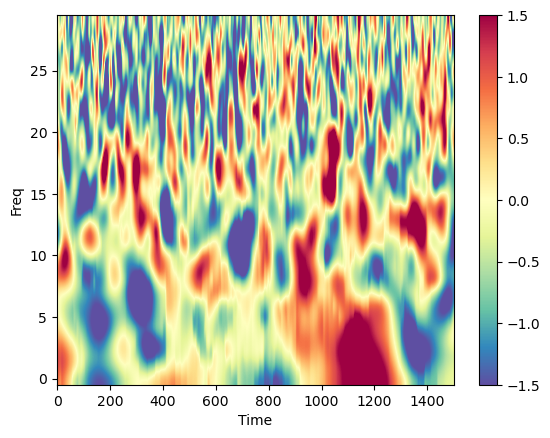

In [91]:
plt.imshow(tstats, interpolation = 'Bicubic',cmap='Spectral_r', aspect='auto',origin='lower',vmin=-1.5,vmax=1.5) 
plt.colorbar()
plt.ylabel('Freq')
plt.xlabel('Time')
plt.title(f'{power_epochs.ch_names[16]} tstats')
plt.show()

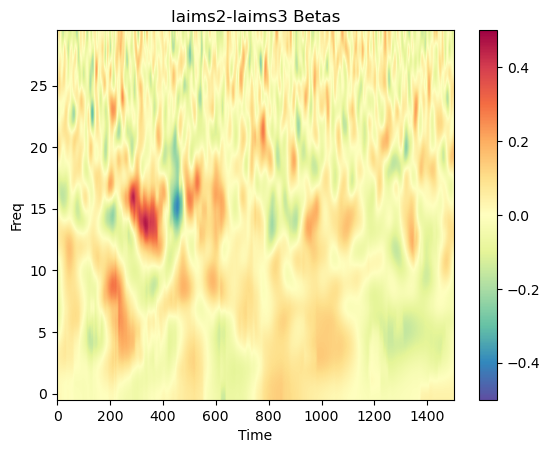

In [18]:
plt.imshow(betas, interpolation = 'Bicubic',cmap='Spectral_r', aspect='auto',origin='lower',vmin=-.5,vmax=.5) 
plt.colorbar()
plt.ylabel('Freq')
plt.xlabel('Time')
plt.title(f'{power_epochs.ch_names[16]} Betas')
plt.show()

In [16]:
max_cluster_data  = cluster_test.max_tfr_cluster(tstats,output='all')


In [17]:
max_cluster_data

[{'cluster_stat': 826.9696754956394,
  'freq_idx': (12, 17),
  'time_idx': (273, 398)},
 {'cluster_stat': -416.76001835645775,
  'freq_idx': (14, 21),
  'time_idx': (433, 471)}]

## Step 3: Compute Null Cluster Distribution from Permutations

In [22]:
null_cluster_distribution = cluster_test.compute_null_cluster_stats(num_permutations=500)

In [24]:
np.mean(null_cluster_distribution[0])

594.0433527703707

In [23]:
np.mean(null_cluster_distribution[1])

-736.784573317732

In [25]:
null_cluster_distribution

[[201.35671537244207,
  1065.3348147768234,
  1093.158654882219,
  459.7599217332959,
  291.6724803449092,
  180.75500631889344,
  1428.2239607675044,
  181.19152795211798,
  549.4013312610225,
  546.9784918369286,
  365.1936111089518,
  289.4713256144422,
  616.961081710059,
  1255.6176190240662,
  486.09388178874525,
  722.6061279739267,
  1522.4304869238335,
  735.8546965603282,
  1604.00642478881,
  583.6502253378958,
  376.0143476306315,
  420.4389322954748,
  247.35410233468383,
  881.6131559845769,
  1289.4858116892474,
  992.385348204517,
  519.6041585762532,
  457.01396413001015,
  191.67002054457794,
  298.89982491269546,
  167.45592962948595,
  457.97204329359903,
  249.83298337906513,
  895.5927956576195,
  329.1354960713255,
  194.73638350893498,
  201.33230410157435,
  1260.6847813986492,
  266.67009972954975,
  337.9372603843126,
  869.2037028586335,
  131.31365750856062,
  129.29155057820714,
  2298.9114260582974,
  409.6774851104476,
  402.82083430099397,
  970.4508883

In [26]:
cluster_pvalue = cluster_test.cluster_significance_test(max_cluster_data,null_cluster_distribution) #compute_cluster_pvalue cluster_significance_test


In [27]:
cluster_pvalue

[0.204, 0.64]

#### POLISHED WORKFLOW

In [ ]:
### NeuroCluster single electrode workflow: 

# Step 1: Create TFR_Cluster_Test Object
cluster_test  = TFR_Cluster_Test(tfr_data,predictor_data,permute_var,ch_name,alternative='two-sided')

# Step 2: Run TFR regression to extract beta coefficients for predictor of interest (permute_var) & tstats for each pixel in TFR
betas, tstats = cluster_test.tfr_regression()

# Step 3: Find largest cluster(s) and return the max cluster statistic(s) and cluster's  frequencies x times indices
max_cluster_data  = cluster_test.max_tfr_cluster(tstats,output='all')

# Step 4: Create null distribution of maximum cluster statistics from permuted data
null_cluster_distribution = cluster_test.compute_null_cluster_stats(num_permutations=10)

# Step 5: Use null cluster statistic distribution from permutations to compute non-parametric p value 
cluster_pvalue = cluster_test.cluster_significance_test(max_cluster_data,null_cluster_distribution,alpha=0.05) #compute_cluster_pvalue cluster_significance_test



In [ ]:
# To implement FDR correction: 
# https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html
# multitest.multipletests(p_upper, method='fdr_bh')

In [ ]:
        # null_df = pd.concat([pd.DataFrame(dict,index=[0]) for dict in null_distribution]).reset_index(drop=True)
        # null_df['sign'] = ['positive' if row.cluster_stat > 0 else 'negative' for row in null_df.iterrows()]
        # for sign in null_df.sign.unique(): #### one loop option 
        # for cluster in max_cluster_stat: ### another loop option
        #     null_max_clusters = null_df.cluster_stat[null_df.sign == sign]
